# <center>Сегментация космических аппаратов
Датасет был взят [<b>отсюда</b>](https://github.com/Yurushia1998/SatelliteDataset)

<img src='./imgs/preview.png'></img>

* Данный датасет состоит из 3 116 изображений и масок как синтезированных, так и реальных изображений спутников и космических станций (размер масок — 1 280x720).

* Каждый космический аппарат разделён максимум на три части, включая корпус, солнечную панель и антенну, помеченные, соответственно, тремя цветами — зелёным, красным и синим.

* В папке `images` находятся изображения, в папке `mask` — маски объектов.

* Изображение с индексом 0-1002 имеет точную маску, а изображения с индексом 1003-3116 — грубую маску.

* Наборы данных разделены на две части: обучающую выборку, включая 403 точные маски из индексов 0-402, и 2 114 грубых масок из индекса 1003-3116.

* Набор данных `val` включает 600 изображений с точной маской, проиндексированных от 403 до 1002.

Будем использовать модель семейства *YOLO*. Импортируем необходимые библиотеки

In [1]:
import os
import cv2 as cv
import torch
import numpy as np
import re
import plotly.express as px
import plotly.io as pio
import shutil
from plotly.subplots import make_subplots
from ultralytics.models import YOLO
from torchmetrics import JaccardIndex
from torchvision import io
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
DATASET_PATH = './dataset'
IMG_PATH = './data/images'
MASK_PATH = './data/mask'

Создадим функции для удобства обработки датасета

In [2]:
# 'img_resize_001.png' -> '001'
def get_image_index(img_name:str) -> str:
    return re.findall(r'\d+', img_name)[0]

# 'img_resize_001.png' -> 'img_resize_001'
def get_image_name(img_name:str) -> str:
    return re.findall(r'([a-zA-Z0-9_-]+)\.', img_name)[0]

# 'img_resize_001_mask.png' -> 'img_resize_001.txt'
def modify_mask_name(mask_name:str) -> str:
    result = re.sub(r'\.png$', '.txt', mask_name)
    result = re.sub(r'\_mask', '', result)
    return result

Визуализируем несколько примеров из датасета

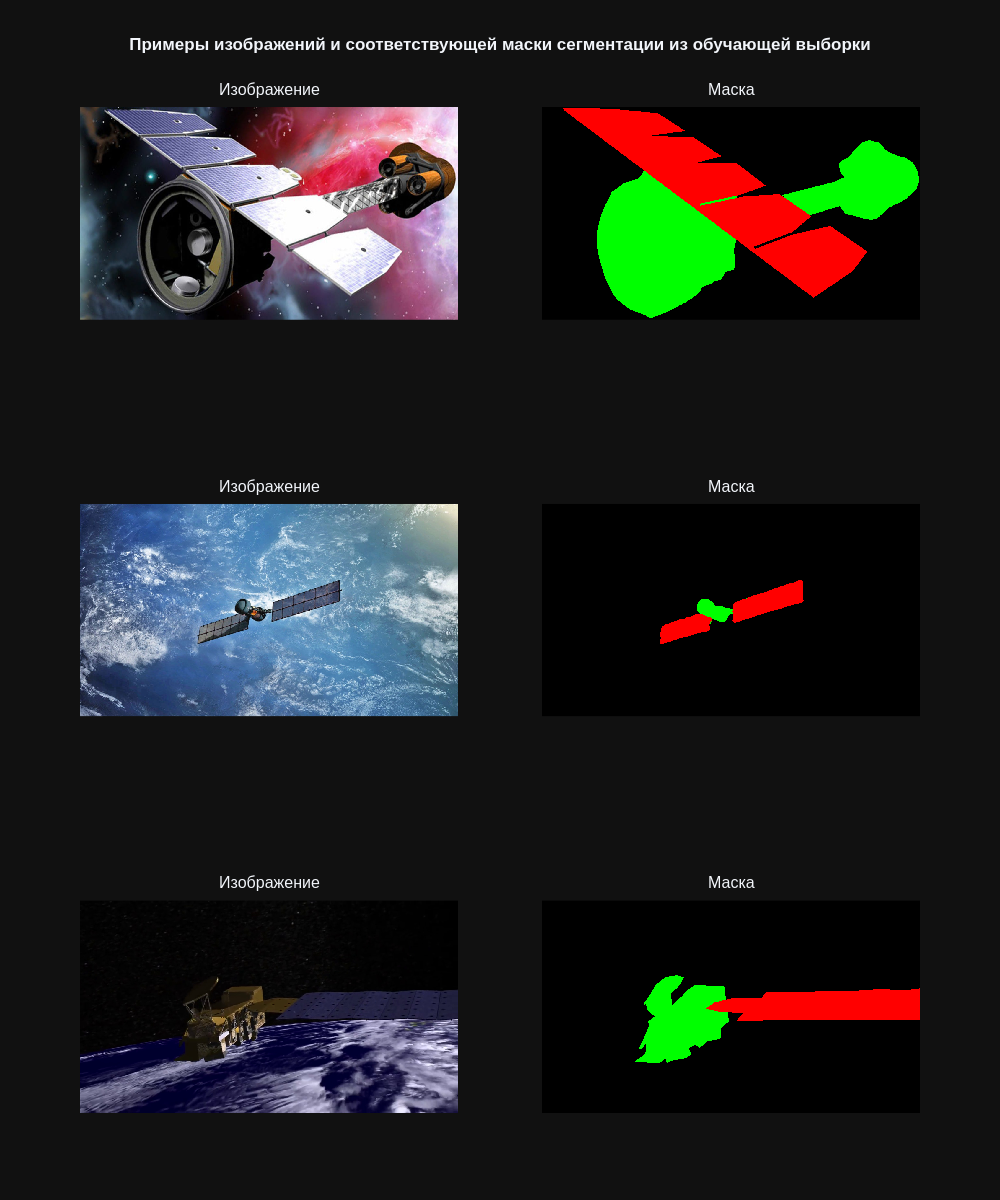

In [3]:
nrows = 3
ncols = 2
grid = make_subplots(rows=nrows, cols=ncols, subplot_titles=['Изображение', 'Маска']*nrows)
for row, img in zip(
    range(1, nrows+1),
    os.listdir(os.path.join(IMG_PATH, 'train'))[:nrows]
):
    # Add image
    grid.add_trace(
        trace=px.imshow(
            # BGR -> RGB
            cv.cvtColor(
                cv.imread(os.path.join(IMG_PATH, 'train', img)),
                cv.COLOR_BGR2RGB
            )
        ).data[0],
        row=row,
        col=1
    )
    # Add mask
    grid.add_trace(
        trace=px.imshow(
            # BGR -> RGB
            cv.cvtColor(
                cv.imread(os.path.join(MASK_PATH, 'train', get_image_name(img)+'_mask.png')),
                cv.COLOR_BGR2RGB
            )
        ).data[0],
        row=row,
        col=2
    )
# Configure plot
grid.update_layout(
    width=1000, 
    height=1200,
    title='<b>Примеры изображений и соответствующей маски сегментации из обучающей выборки</b>',
    title_x=0.5
).update_xaxes(
    visible=False
).update_yaxes(
    visible=False
).show()

Сейчас данные находятся в следующей структуре:

In [4]:
!tree ./data -d

./data
├── images
│   ├── train
│   └── val
└── mask
    ├── train
    └── val

6 directories


С помощью следующей ячейки создадим структуру датасета, которая необходима для *YOLO*

Код проходит по всем файлам масок в папке `./data/mask`. Для каждого файла маски создается соответствующий файл метки в формате `.txt` в папке `labels`, а также копируется оригинальное изображение в соответствующую папку `images`.

С помощью *OpenCV* находим контуры объектов на каждом канале маски и преобразуем их в формат $(x_1, y_1, x_2, y_2, \dots, x_n, y_n)$

В результирующем файле-таргете `*.txt` получается следующая структура: `<class> <x1, y1, x2, y2, ..., xn, yn>`, где `<class>` соответствует каналу *RGB* изображения (0, 1 или 2). На 0 канале размечены солнечные панели, на 1 - основное тело аппарата, на 2 - антенны

In [5]:
for sample in ['train', 'val']:
    labels_path = os.path.join(DATASET_PATH, sample, 'labels')
    images_path = os.path.join(DATASET_PATH, sample, 'images')
    # Make train and val dirs
    if not os.path.exists(labels_path):
        os.makedirs(labels_path)
    if not os.path.exists(images_path):
        os.makedirs(images_path)
    # Check if labels already exists
    if len(os.listdir(labels_path)) == 0:
        # Iterate over all segmentation masks
        for mask_name in os.listdir(os.path.join(MASK_PATH, sample)):
            # *_mask.png -> *.png
            img_name = re.sub(r'\_mask', '', mask_name)
            # Copy the corresponding image to the mask (if exists) from `./data/images/sample` to `./dataset/sample/images`
            if img_name in os.listdir(os.path.join(IMG_PATH, sample)):
                shutil.copy(os.path.join(IMG_PATH, sample, img_name), os.path.join(images_path))
            else:
                # Skip masks without source image
                continue
            # Mask Tensor [C, H, W]
            img = io.read_image(os.path.join(MASK_PATH, sample, mask_name))
            height, width = img.shape[1], img.shape[2]
            # *_mask.png -> *.txt for label file
            label_name = modify_mask_name(mask_name)
            # img_resize_1003_mask.png -> 1003
            img_idx = get_image_index(mask_name)
            # Target string initial state
            labels_string = ''
            # Iterate over R, G, B (0, 1, 2) channels,
            # each channel contains a mask of a certain class:
            # 0 - solar panel, 1 - body, 2 - antenna
            for channel in range(3):
                # Skip empty channel without segmentation mask
                if img[channel].max().item() == 0:
                    continue
                # Get countours of segmented objects 
                contours = cv.findContours(img[channel].numpy(), mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_NONE)[0]
                for contour in contours:
                    # Reshape countour to 1D array: [x1, y1, x2, y2, ...]
                    contour_squeezed = contour.reshape(-1,).tolist()
                    # Normalize contour coordinates
                    for coord_idx in range(len(contour_squeezed)):
                        current_coordinate = contour_squeezed[coord_idx]
                        if bool(coord_idx % 2):
                            # Normalize Y, convert to string for more convenient writing to a file
                            contour_squeezed[coord_idx] = str(current_coordinate / height)
                        else:
                            # Normalize X
                            contour_squeezed[coord_idx] = str(current_coordinate / width)
                    # Convert to string 'x1 y1 x2 y2 ...'
                    string_contour = ' '.join(contour_squeezed)
                    # Add row to target in format '<class> <segmentation_contour>'
                    labels_string += f"{channel} {string_contour}\n"
            # Write target file
            with open(os.path.join(labels_path, label_name), 'w') as txt_label:
                txt_label.write(labels_string.rstrip(r'\n'))

Проверим теперь структуру датасета

In [6]:
!tree ./dataset -d

./dataset
├── train
│   ├── images
│   └── labels
└── val
    ├── images
    └── labels

6 directories


In [7]:
print(
    'Total train samples:', len(os.listdir(os.path.join(DATASET_PATH, 'train', 'labels'))), '\n'
    'Total val samples:', len(os.listdir(os.path.join(DATASET_PATH, 'val', 'labels'))),
)

Total train samples: 2517 
Total val samples: 600


Загрузим модель `yolov8l-seg` для задачи сегментации. `l` в названии означает *large* и имеет около 46 миллионов обучаемых параметров

In [8]:
yolo = YOLO('yolov8l-seg.pt')

100%|██████████| 88.1M/88.1M [00:02<00:00, 32.4MB/s]


Дообучаем модель на новых данных в течение 50-ти эпох

In [9]:
results = yolo.train(
    model='yolov8l-seg.pt',
    data='yolo.yaml',
    epochs=30,
    imgsz=640,
    batch=8,
    pretrained=True
)

Ultralytics YOLOv8.1.14 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
engine/trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=yolo.yaml, epochs=30, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

2024-02-17 19:18:06.820856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 19:18:06.820911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 19:18:06.877781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

train: Scanning /home/deep_learning/Spacecraft segmentation/dataset/train/labels... 2517 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2517/2517 [00:17<00:00, 147.44it/s]


train: New cache created: /home/deep_learning/Spacecraft segmentation/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/deep_learning/Spacecraft segmentation/dataset/val/labels... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:05<00:00, 119.89it/s]

val: New cache created: /home/deep_learning/Spacecraft segmentation/dataset/val/labels.cache


Plotting labels to runs/segment/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.34G     0.9804      1.799      1.482      1.257         26        640: 100%|██████████| 315/315 [01:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.42it/s]


                   all        600       3200      0.436      0.398      0.367       0.22      0.437      0.441      0.399       0.24

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.64G      1.141      2.042      1.421      1.357         57        640: 100%|██████████| 315/315 [01:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.52it/s]

                   all        600       3200      0.537      0.417      0.396      0.248      0.594      0.429      0.435      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30       6.5G      1.117      1.982      1.348       1.34         49        640: 100%|██████████| 315/315 [01:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.67it/s]

                   all        600       3200      0.541       0.41       0.41      0.261       0.58      0.421      0.432      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.45G      1.089      1.941      1.321      1.333         21        640: 100%|██████████| 315/315 [01:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.09it/s]

                   all        600       3200      0.577       0.43      0.442      0.286      0.606      0.451      0.465      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.64G       1.02      1.776      1.203      1.283         35        640: 100%|██████████| 315/315 [01:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.60it/s]

                   all        600       3200      0.601      0.478      0.469      0.319      0.637      0.468      0.483      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.59G      1.003      1.739       1.16      1.268         30        640: 100%|██████████| 315/315 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.37it/s]

                   all        600       3200      0.594      0.495      0.482      0.331      0.623      0.508      0.503       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.38G     0.9431      1.671      1.071      1.237         38        640: 100%|██████████| 315/315 [01:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.02it/s]

                   all        600       3200      0.643      0.509      0.515      0.356      0.682      0.512      0.539      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.61G     0.9342      1.637      1.046      1.227         31        640: 100%|██████████| 315/315 [01:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.10it/s]


                   all        600       3200      0.647      0.489      0.505       0.35      0.662        0.5      0.515      0.359

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.51G     0.8875      1.552     0.9816      1.201         39        640: 100%|██████████| 315/315 [01:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.04it/s]

                   all        600       3200      0.644       0.48      0.503      0.347      0.663      0.484       0.51      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.59G     0.8635       1.49      0.944      1.188         37        640: 100%|██████████| 315/315 [01:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  7.61it/s]

                   all        600       3200      0.684      0.513      0.533      0.388      0.733       0.51      0.547      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.55G     0.8604      1.499     0.9379      1.175         25        640: 100%|██████████| 315/315 [01:03<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.65it/s]

                   all        600       3200      0.626      0.491      0.516      0.364      0.647      0.498      0.526      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.59G     0.8398      1.435     0.9111      1.168         44        640: 100%|██████████| 315/315 [01:03<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.70it/s]

                   all        600       3200      0.675      0.531      0.532      0.386      0.687      0.541      0.542      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.56G     0.8153      1.403     0.8697      1.146         25        640: 100%|██████████| 315/315 [01:02<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.20it/s]

                   all        600       3200      0.698      0.518      0.553      0.399      0.718      0.533      0.566      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.52G     0.8011      1.356     0.8377      1.138         28        640: 100%|██████████| 315/315 [01:02<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.03it/s]

                   all        600       3200      0.707      0.536       0.56      0.406       0.73       0.54      0.568      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.55G     0.7727      1.318     0.8102      1.125         37        640: 100%|██████████| 315/315 [01:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.93it/s]

                   all        600       3200      0.695      0.519       0.56       0.41      0.715      0.531      0.571      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.61G     0.7657      1.292     0.7869      1.114         49        640: 100%|██████████| 315/315 [01:01<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.17it/s]

                   all        600       3200      0.676      0.538      0.551       0.41      0.684      0.553      0.562      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.51G     0.7573      1.283     0.7743       1.11         28        640: 100%|██████████| 315/315 [01:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.91it/s]

                   all        600       3200       0.72      0.537      0.568      0.421      0.738       0.55      0.578      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.56G     0.7242      1.219     0.7166      1.085         45        640: 100%|██████████| 315/315 [01:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.29it/s]

                   all        600       3200      0.699      0.551      0.577      0.429      0.719      0.551       0.58       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.64G     0.7108      1.178     0.6978      1.076         40        640: 100%|██████████| 315/315 [01:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.15it/s]

                   all        600       3200      0.715      0.558      0.575      0.429      0.741      0.559      0.585      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.45G     0.6991      1.158     0.6797      1.068         28        640: 100%|██████████| 315/315 [01:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.93it/s]

                   all        600       3200      0.734      0.558       0.59      0.444      0.767      0.558      0.593      0.444


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30       6.5G     0.7032      1.129     0.6719      1.098         24        640: 100%|██████████| 315/315 [01:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.14it/s]

                   all        600       3200      0.715      0.543      0.572      0.424      0.744      0.555      0.588      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.45G     0.6791        1.1     0.6439      1.075         23        640: 100%|██████████| 315/315 [01:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.38it/s]

                   all        600       3200      0.689      0.546       0.58      0.437      0.719      0.541      0.585       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30       6.5G     0.6585      1.048     0.6142      1.061         17        640: 100%|██████████| 315/315 [01:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.31it/s]

                   all        600       3200      0.738      0.552       0.59      0.438      0.758      0.559      0.593       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.46G     0.6478      1.011     0.5846      1.048         20        640: 100%|██████████| 315/315 [01:02<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.30it/s]

                   all        600       3200      0.746      0.552      0.596      0.451      0.763      0.565      0.607      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.44G     0.6349     0.9888     0.5667      1.043         18        640: 100%|██████████| 315/315 [01:02<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.78it/s]

                   all        600       3200      0.768      0.539      0.598      0.451      0.786       0.55      0.605      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.48G     0.6158     0.9704     0.5373      1.027         13        640: 100%|██████████| 315/315 [01:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.40it/s]

                   all        600       3200      0.724      0.579      0.598       0.45      0.743      0.586      0.605      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.46G     0.6006     0.9229     0.5049       1.02         34        640: 100%|██████████| 315/315 [01:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.93it/s]

                   all        600       3200      0.772      0.553      0.598      0.447       0.78      0.567      0.606      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.51G      0.586     0.9166     0.4908      1.004          9        640: 100%|██████████| 315/315 [01:02<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.03it/s]

                   all        600       3200      0.767      0.561      0.606      0.462      0.774      0.567       0.61      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30       6.5G     0.5654     0.8872     0.4615     0.9869         12        640: 100%|██████████| 315/315 [01:02<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.20it/s]

                   all        600       3200      0.768      0.559      0.603      0.458      0.799      0.567       0.61      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.25G     0.5524     0.8588     0.4453     0.9836         11        640: 100%|██████████| 315/315 [01:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.83it/s]

                   all        600       3200      0.766      0.574      0.611      0.468      0.787      0.582       0.62      0.472



30 epochs completed in 0.577 hours.
Optimizer stripped from runs/segment/train4/weights/last.pt, 92.3MB
Optimizer stripped from runs/segment/train4/weights/best.pt, 92.3MB

Validating runs/segment/train4/weights/best.pt...
Ultralytics YOLOv8.1.14 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
YOLOv8l-seg summary (fused): 295 layers, 45914201 parameters, 0 gradients, 220.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  6.45it/s]


                   all        600       3200      0.763      0.574      0.611      0.468      0.787      0.582       0.62      0.472
           solar panel        600       1382      0.854      0.724       0.78      0.655      0.867      0.729       0.78      0.665
                  body        600       1407      0.778      0.449      0.482      0.351        0.8      0.458      0.482      0.342
               antenna        600        411      0.658       0.55      0.572      0.397      0.693       0.56      0.598      0.409
Speed: 0.1ms preprocess, 4.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/train4


## <center>Оценка качества</center>
### История обучения
<img src='./imgs/results.png' width=1400></img>

Возможно, если дать модели больше времени на обучение, то получится достичь ещё более высоких показателей метрик на валидации без переобучения

Загрузим наилучшую модель

In [10]:
best_model_path = './runs/segment/train4/weights/best.pt'
best_yolo = YOLO(best_model_path)

Посчитаем метрики на валидационной выборке

In [11]:
val_metrics = best_yolo.val(split='val')

Ultralytics YOLOv8.1.14 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)


YOLOv8l-seg summary (fused): 295 layers, 45914201 parameters, 0 gradients, 220.1 GFLOPs


val: Scanning /home/deep_learning/Spacecraft segmentation/dataset/val/labels.cache... 600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:08<00:00,  4.29it/s]


                   all        600       3200      0.765      0.574      0.611      0.467      0.787      0.582      0.619      0.471
           solar panel        600       1382      0.855      0.724      0.778      0.655      0.868      0.729      0.779      0.664
                  body        600       1407       0.78      0.449      0.482      0.351      0.801      0.459      0.483      0.342
               antenna        600        411      0.661      0.549      0.571      0.397      0.692       0.56      0.596      0.408
Speed: 0.1ms preprocess, 7.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/val


### Визуализация метрик на валидационной выборке
#### *PR curve*
<img src='./imgs/MaskPR_curve.png' height=800></img>

#### *Confusion matrix*
<img src='./imgs/confusion_matrix.png' height=800></img>

### *F1-confidence curve*
<img src='./imgs/MaskF1_curve.png' height=800></img>

Вручную посчитаем метрику $\text{mIoU}$ для валидационной выборки, т.к. в валидаторе *YOLO* не используется эта метрика по-умолчанию

In [19]:
# Binary for the reason that we want to calculate the mIoU for objects,
# and not its individual parts 
IoU = JaccardIndex(task='binary').cuda()
val_img_path = './dataset/val/images'
# Cumulative array
iou_array = np.array([])
# Iterate over every image in val sample
for image_name in os.listdir(val_img_path):
    # *.png -> *_mask.png to get real label from another folder ./data/mask/val
    real_mask_name = get_image_name(image_name) + '_mask.png'
    # Predict segmentation masks for image
    output = best_yolo.predict(os.path.join(val_img_path, image_name), verbose=False)
    # Read real mask in grayscale
    real_mask_gray = cv.imread(
        os.path.join(MASK_PATH, 'val', real_mask_name),
        flags=cv.IMREAD_GRAYSCALE
    )
    # Convert all pixels with brightness > 0 from [0, ..., 255] to [0, 1]
    _, real_mask_binary = cv.threshold(
        # Match real size with predicted segmentation mask size:
        # YOLO predicted seg. masks from `output.masks.data` is [384, 640],
        # our original sizes of all images is [H=720, W=1280]
        cv.resize(real_mask_gray, (640, 384)), # OpenCV using dsize [W, H] instead of [H, W]
        # Each non-zero pixel turns 1
        thresh=1,
        maxval=1,
        type=cv.THRESH_BINARY
    )
    # Skip computing IoU if no detections
    if output[0].masks is not None:
        # Tensor [C, H, W], where C - number of detections,
        # for example [2, H, W] means that model predicted at least 2 objects on image 
        pred_masks = output[0].masks.data
        # Make cumulative mask [H, W] for predictions
        pred_mask_binary = np.zeros_like(
            real_mask_binary, 
            dtype=np.float32
        )
        # Iterate over every channel C (every detected object) on predictions
        for mask in pred_masks:
            # Combine all objects on one mask (reduce dims from [C, H, W] to [H, W])
            pred_mask_binary = cv.bitwise_or(
                mask.cpu().numpy(),
                pred_mask_binary
            )
        # Compute IoU between predicted mask and real mask, add value to array
        iou_array = np.append(
            iou_array, 
            IoU(
                torch.Tensor(pred_mask_binary).cuda(), 
                torch.Tensor(real_mask_binary).cuda()
            ).cpu().item()
        )

Выведем результат, округлив до тысячных

In [20]:
print('mIoU =', iou_array.mean().round(3))

mIoU = 0.836


Сделаем несколько предсказаний

In [21]:
image_batch = list(map(lambda img_name: os.path.join(val_img_path, img_name), os.listdir(val_img_path)[:4]))
predictions = best_yolo.predict(image_batch, save=True)

Results saved to runs/segment/predict


Отобразим их, чтобы визуально оценить качество работы модели

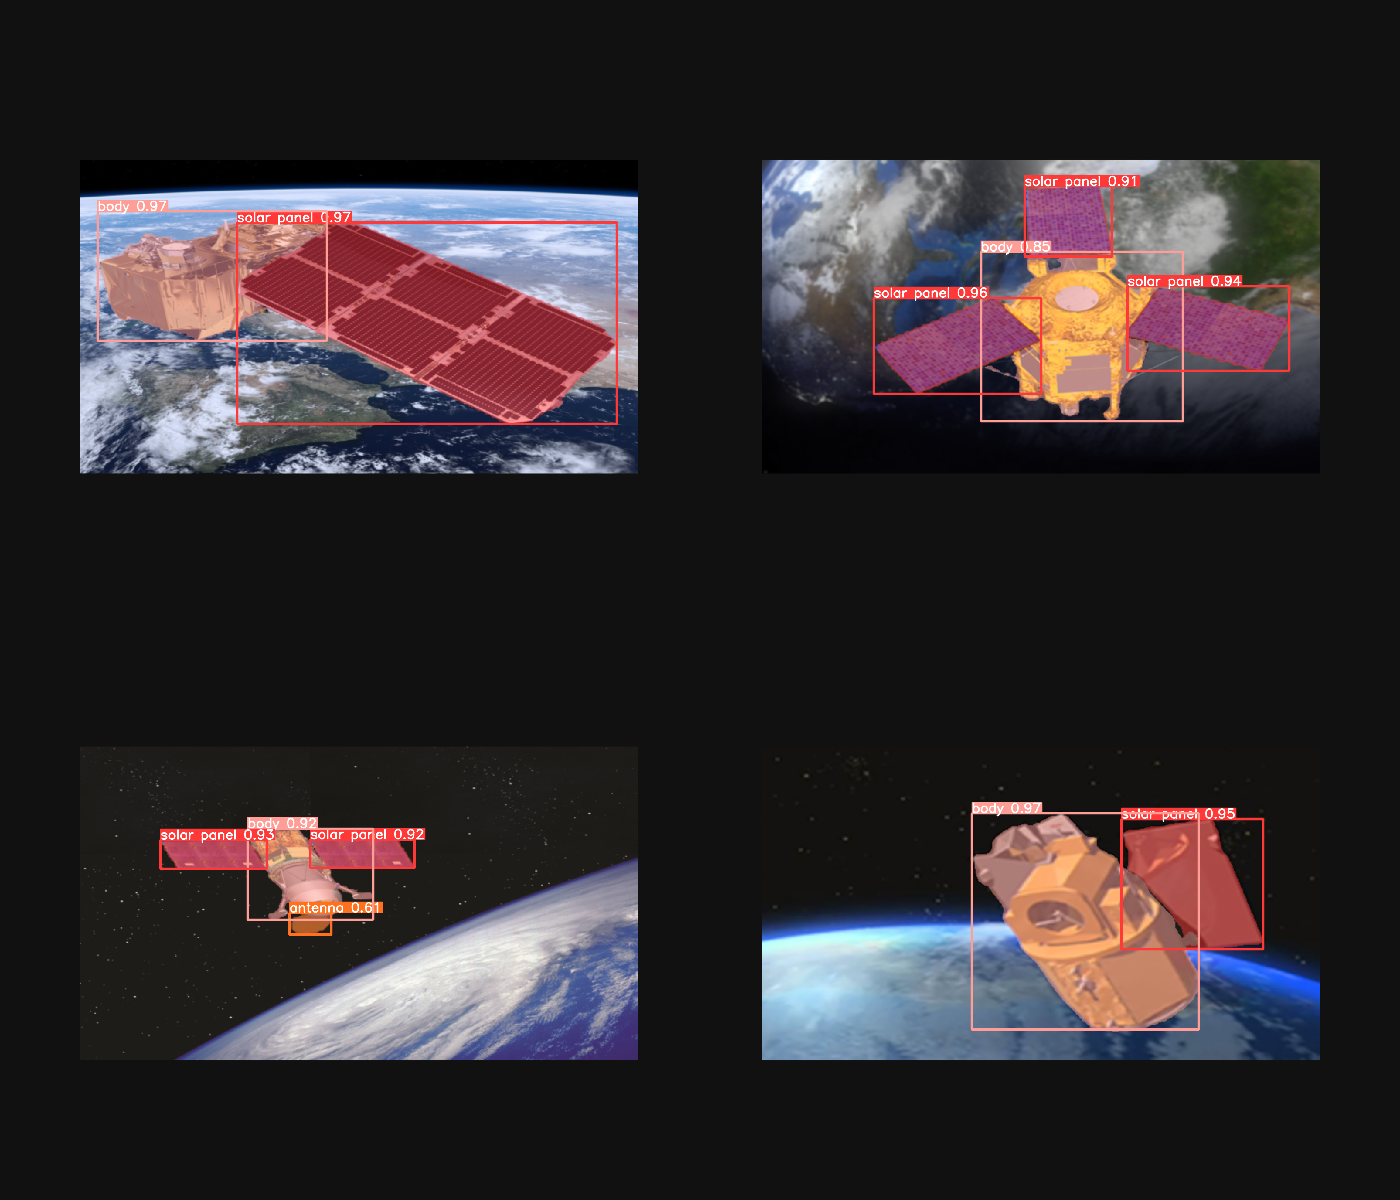

In [22]:
rows = cols = 2
grid = make_subplots(rows=rows, cols=cols)
predictions_path = 'runs/segment/predict'
for row, col, image in zip(
    sorted(list(range(1, rows+1))*cols),
    list(range(1, cols+1))*rows,
    os.listdir(predictions_path)
):
    # Add image with predicted segmentation mask and box with label
    grid.add_trace(
        px.imshow(
            # BGR -> RGB
            cv.cvtColor(
                cv.imread(os.path.join(predictions_path, image)),
                cv.COLOR_BGR2RGB
            )
        ).data[0],
        row=row,
        col=col
    )
# Configure plot
grid.update_layout(
    width=1400, 
    height=1200
).update_xaxes(
    visible=False
).update_yaxes(
    visible=False
).show()